<a href="https://colab.research.google.com/github/linkzero177/Fatal-Police-Shootings-in-the-US/blob/master/Reports/KaggleReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
over_25_completed_hs = pd.read_csv('/content/drive/My Drive/data/fatal-police-shootings-in-the-us/PercentOver25CompletedHighSchool.csv', encoding="windows-1252")
people_below_poverty = pd.read_csv('/content/drive/My Drive/data/fatal-police-shootings-in-the-us/PercentagePeopleBelowPovertyLevel.csv', encoding="windows-1252")
median_household_income = pd.read_csv('/content/drive/My Drive/data/fatal-police-shootings-in-the-us/MedianHouseholdIncome2015.csv', encoding="windows-1252")
share_race_by_city = pd.read_csv('/content/drive/My Drive/data/fatal-police-shootings-in-the-us/ShareRaceByCity.csv', encoding="windows-1252")
fatal_police_shooting_us = pd.read_csv('/content/drive/My Drive/data/fatal-police-shootings-in-the-us/FatalPoliceShootingUS.csv', encoding="windows-1252")

# **Processing**

Drop missing rows and convert string to float64

In [25]:
# dropping rows with missing percent_completed_hs
over_25_completed_hs = over_25_completed_hs[over_25_completed_hs['percent_completed_hs'] != '-']
over_25_completed_hs['percent_completed_hs'] = over_25_completed_hs['percent_completed_hs'].astype('float64')

people_below_poverty = people_below_poverty[people_below_poverty['poverty_rate'] != '-']
people_below_poverty['poverty_rate'] = people_below_poverty['poverty_rate'].astype('float64')

median_household_income = median_household_income[median_household_income['Median Income'] != '(X)']
median_household_income = median_household_income[median_household_income['Median Income'] != '-']
median_household_income = median_household_income[median_household_income['Median Income'].notna()]

# drop 250000+ and 2500-
median_household_income = median_household_income[~median_household_income['Median Income'].str.contains('-')]
median_household_income = median_household_income[~median_household_income['Median Income'].str.contains('+', regex=False)]

median_household_income['Median Income'] = median_household_income['Median Income'].astype('float64')

share_race_by_city = share_race_by_city[share_race_by_city['share_white']!='(X)']
share_race_by_city['share_white'] = share_race_by_city['share_white'].astype('float64')

share_race_by_city['share_black'] = share_race_by_city['share_black'].astype('float64')
share_race_by_city['share_native_american'] = share_race_by_city['share_native_american'].astype('float64')
share_race_by_city['share_asian'] = share_race_by_city['share_asian'].astype('float64')
share_race_by_city['share_hispanic'] = share_race_by_city['share_hispanic'].astype('float64')

fatal_police_shooting_us['date'] = pd.to_datetime(fatal_police_shooting_us['date'], format='%d/%m/%y')
fatal_police_shooting_us = fatal_police_shooting_us.dropna()

Combine over_25_completed_hs, people_below_poverty, median_household_income, share_race_by_city to a demographic dataset

In [26]:
a = [people_below_poverty.set_index(['Geographic Area', 'City']), median_household_income.set_index(['Geographic Area', 'City']), share_race_by_city.set_index(['Geographic area', 'City'])]
demographic = over_25_completed_hs.set_index(['Geographic Area', 'City']).join(other=a).reset_index()
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29132 entries, 0 to 29131
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Geographic Area        29132 non-null  object 
 1   City                   29132 non-null  object 
 2   percent_completed_hs   29132 non-null  float64
 3   poverty_rate           29125 non-null  float64
 4   Median Income          27383 non-null  float64
 5   share_white            28930 non-null  float64
 6   share_black            28930 non-null  float64
 7   share_native_american  28930 non-null  float64
 8   share_asian            28930 non-null  float64
 9   share_hispanic         28930 non-null  float64
dtypes: float64(8), object(2)
memory usage: 2.2+ MB


Trying to combine demographic with fatal_police_shooting to make a single dataset.
We need to fix the mitmatch in city naming convention between fatal_police_shooting and demographic

In [27]:
demographic['City'] = demographic['City'].str.replace(' city.*','')
demographic['City'] = demographic['City'].str.replace(' CDP.*','')
demographic['City'] = demographic['City'].str.replace(' town.*','')
demographic = demographic.rename(columns={'Geographic Area':'state', 'City':'city'})

data = demographic.set_index(['state','city']).join(fatal_police_shooting_us.set_index(['state','city'])).reset_index()
data = data.dropna(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1938 entries, 25 to 29882
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   state                    1938 non-null   object        
 1   city                     1938 non-null   object        
 2   percent_completed_hs     1938 non-null   float64       
 3   poverty_rate             1938 non-null   float64       
 4   Median Income            1938 non-null   float64       
 5   share_white              1938 non-null   float64       
 6   share_black              1938 non-null   float64       
 7   share_native_american    1938 non-null   float64       
 8   share_asian              1938 non-null   float64       
 9   share_hispanic           1938 non-null   float64       
 10  id                       1938 non-null   float64       
 11  name                     1938 non-null   object        
 12  date                     1938 no

# **EDA**

**Demographics**

---



In [13]:
demographic.describe()

,percent_completed_hs,poverty_rate,Median Income,share_white,share_black,share_native_american,share_asian,share_hispanic
count,29132.000000,29125.000000,27383.000000,28930.000000,28930.000000,28930.000000,28930.000000,28930.000000
mean,85.733805,16.444045,51177.670672,83.190149,6.882655,2.856685,1.547159,9.203426
std,11.875153,13.176623,24887.873873,21.649996,15.673815,12.627056,4.293338,17.269697
min,0.000000,0.000000,4511.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,81.000000,7.100000,35625.000000,78.500000,0.100000,0.100000,0.000000,1.200000
50%,88.400000,13.700000,45305.000000,92.500000,0.800000,0.300000,0.400000,2.900000
75%,93.500000,22.500000,59482.000000,96.900000,4.300000,0.900000,1.200000,8.000000
max,100.000000,100.000000,244083.000000,100.000000,100.000000,100.000000,67.100000,100.000000


*   85.7% of people over 25 completed high school
*   Average median income is 51177
*   16.4% of people are in poverty

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Average race share in US')

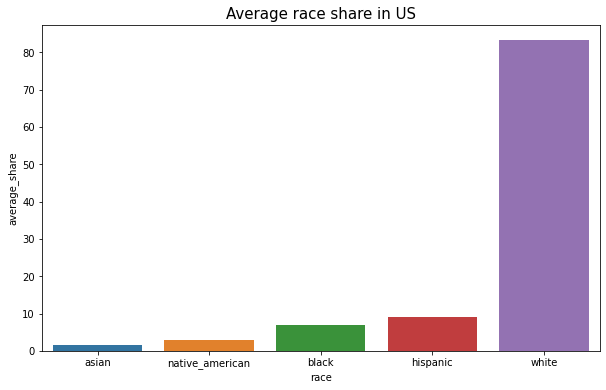

In [12]:
average_share_per_race = pd.DataFrame({'race':['white','black','native_american','asian','hispanic'],
                                       'average_share':[83.190149,6.882655,2.856685	,1.547159,9.203426]})
average_share_per_race = average_share_per_race.sort_values(by='average_share')
plt.figure(figsize=(10,6))
plt.title('Average race share in US', fontdict={'fontsize':15})
sns.barplot(x=average_share_per_race['race'], y=average_share_per_race['average_share'])

It is clear that white accounts for the majority of the population in the US

Text(0.5, 1.0, 'Median Income')

Text(0.5, 1.0, 'Poverty Rate')

Text(0.5, 1.0, 'Percent Completed High School')

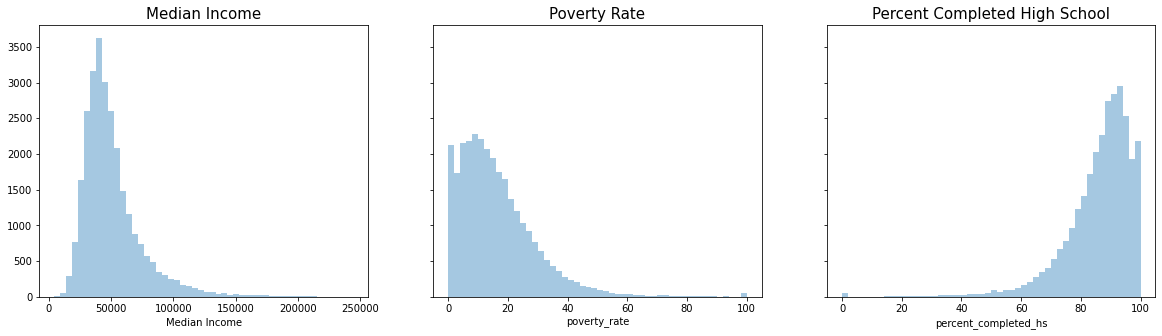

In [14]:
fig, ax = plt.subplots(1,3,figsize=(20,5), sharey=True)

#ax[0].ticklabel_format(style='plain')
sns.distplot(demographic['Median Income'], ax=ax[0], kde=False)
ax[0].set_title('Median Income', fontdict={'fontsize': 15})

sns.distplot(demographic['poverty_rate'], ax=ax[1], kde=False)
ax[1].set_title('Poverty Rate', fontdict={'fontsize': 15})

sns.distplot(demographic['percent_completed_hs'], ax=ax[2], kde=False)
ax[2].set_title('Percent Completed High School', fontdict={'fontsize': 15})

Text(0.5, 1.0, 'Poverty rate and Median Income')

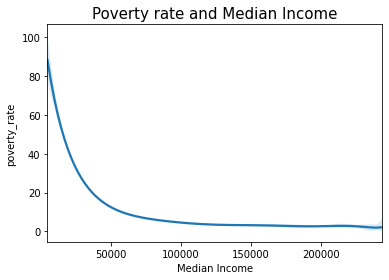

In [15]:
plt.title('Poverty rate and Median Income', fontdict={'fontsize':15})
sns.regplot(x = demographic['Median Income'], y = demographic['poverty_rate'], order=10, scatter=False)

There is a reasonable trend between median income and poverty rate of each city.

**Fatal police shooting US**

---

In [31]:
fatal_police_shooting_us['date'].sort_values()

0      2015-01-02
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-04
          ...    
2519   2017-07-25
2523   2017-07-26
2525   2017-07-27
2533   2017-07-31
2534   2017-07-31
Name: date, Length: 2254, dtype: datetime64[ns]

The data was collected from 2015-01-02 till 2017-07-31

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


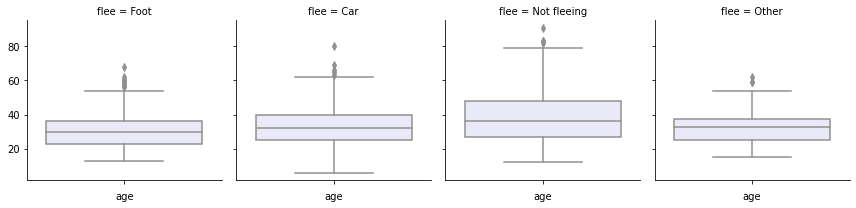

In [34]:
grid = sns.FacetGrid(fatal_police_shooting_us,col='flee',col_order=['Foot','Car','Not fleeing','Other'])
grid.map(sns.boxplot, 'age', orient='vertical', color='lavender')

Age of the victims doesn't seem to have much influence on their fleeing method.

Text(0.5, 1.0, 'Average age for each gender and race')

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
60,20,Jessie Hernandez,2015-01-26,shot,vehicle,17.0,F,H,Denver,CO,False,other,Not fleeing,False
149,189,Jessica Uribe,2015-02-28,shot,knife,28.0,F,H,Tucson,AZ,False,other,Not fleeing,False
737,871,Norma Angelica Guzman,2015-09-27,shot,knife,37.0,F,H,Los Angeles,CA,True,other,Not fleeing,True
1504,1695,Melissa Ventura,2016-07-05,shot,knife,24.0,F,H,Yuma,AZ,False,other,Not fleeing,False


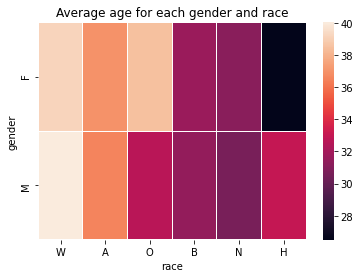

In [35]:
a=pd.pivot_table(data=fatal_police_shooting_us, values='age', index='gender', columns='race')
a=a.reindex(columns=['W','A','O','B','N','H'])
plt.title('Average age for each gender and race')
sns.heatmap(a, mask=a.isnull(), linewidth=0.01, linecolor='white')
fatal_police_shooting_us[(fatal_police_shooting_us['gender']=='F') & (fatal_police_shooting_us['race']=='H')]

!Note:

*   W: White
*   B: Black
*   A: Asian
*   H: Hispanic
*   N: Native American
*   O: Other

White vitims in average are the oldest, whereas Native American and Hispanic are the youngest.
For all races except White and Hispanic, Male vitims tend to be younger.

Female Hispanic are noticably younger than the others. So I tried to select cases in which Female Hispanic were victimes. As a result, there was only 4 cases. The sample is too small to make any inference.

Text(0.5, 1.0, 'Victims with sign of mental illness')

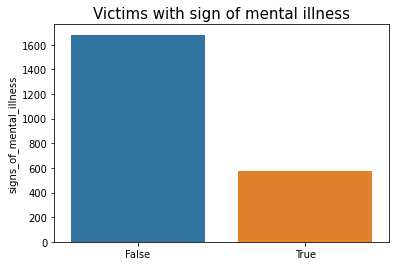

In [46]:
a = fatal_police_shooting_us['signs_of_mental_illness'].value_counts()
plt.title('Victims with sign of mental illness',fontdict={'fontsize':15})
sns.barplot(x= a.index, y = a)

Mental illness of the victim can be a factor that accounts for the decision of the police officers. About 3/8 of the victims had sign of mental illness.

Text(0.5, 1.0, "Victims' status immediately before the fatal shots")

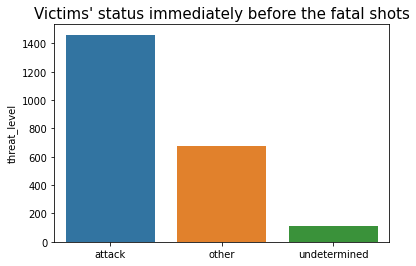

In [47]:
a = fatal_police_shooting_us['threat_level'].value_counts()
plt.title('Victims\' status immediately before the fatal shots',fontdict={'fontsize':15})
sns.barplot(x= a.index, y = a)

About 2/3 of the victims were attacking the police before getting shot. This could also influence the officers' decisions.

Number of unique weapons armed by the victims: 67


<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, 'Top 10 weapons armed by the victims count')

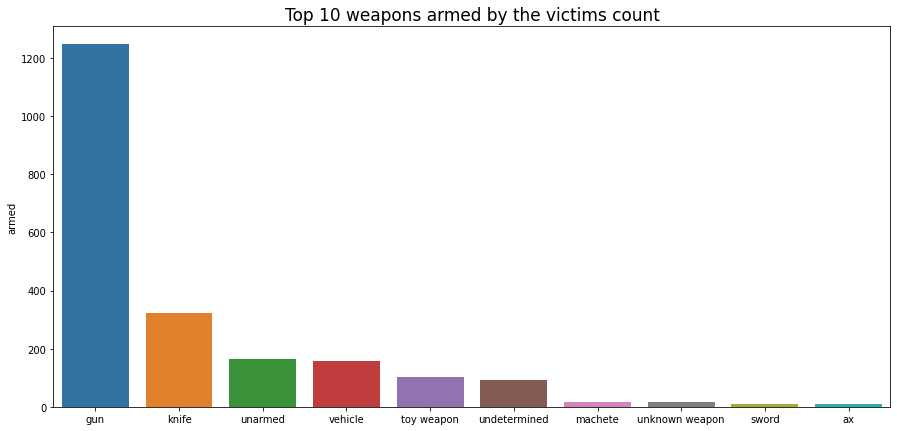

In [48]:
print('Number of unique weapons armed by the victims: {}'.format(len(fatal_police_shooting_us['armed'].unique())))

count_per_weapon = fatal_police_shooting_us['armed'].value_counts()
plt.figure(figsize=(15,7))
plt.title('Top 10 weapons armed by the victims count',fontdict={'fontsize':17})
sns.barplot(x=count_per_weapon[:10].index, y=count_per_weapon[:10])

Most of the victims were having gun before getting shot. Only about 200 of them were unarmed. This raises another question: What were the victims doing with those weapons before the incidence?

<Figure size 720x360 with 0 Axes>

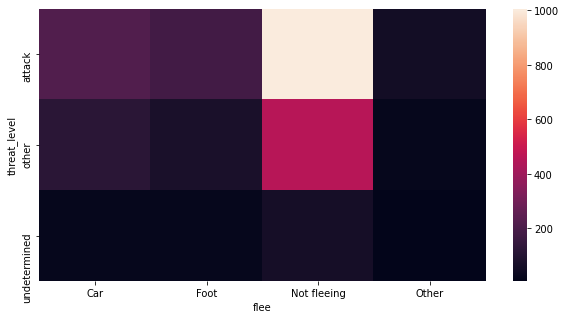

In [49]:
a = fatal_police_shooting_us.groupby(['threat_level','flee']).size()
a = a.reset_index().pivot(index='threat_level',columns='flee',values = 0)
plt.figure(figsize=(10,5))
sns.heatmap(a)

Most of the victims chose not to flee and attack the officers. This helps explain the decision of the officers.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Total number of people killed')

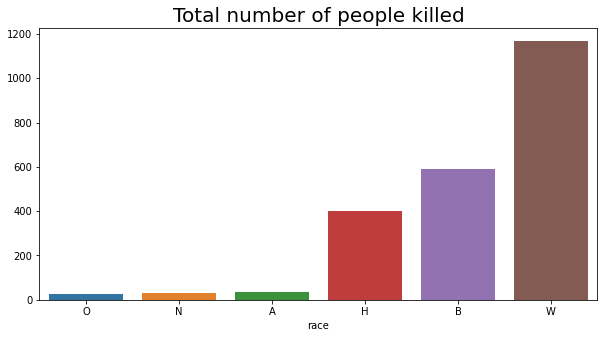

In [36]:
a=fatal_police_shooting_us.groupby('race').size().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=a.index, y=a)
plt.title('Total number of people killed',fontdict={'fontsize':20})

In this chart, we can see that most of the victims were White. However, since the total population of each race in the US is different, especially for White taking a large portion of the US population, a bar plot with the percent people being killed by race would be a better visualization.

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Percent of people per race killed')

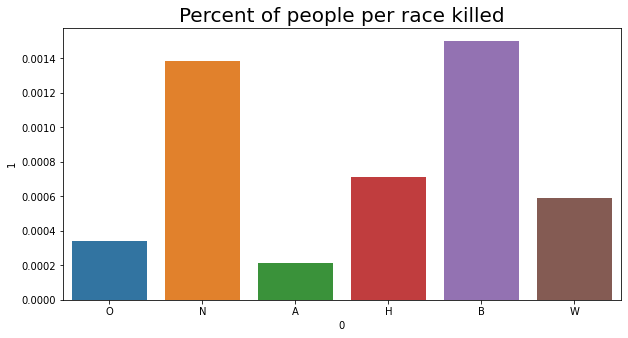

In [39]:
a = fatal_police_shooting_us.groupby('race').size().sort_values()
percent_death_per_race = list()
# these are the population for each race in 2017 collected from https://en.wikipedia.org/wiki/Demographics_of_the_United_States
total_population_per_race = {
    'White':197277789,
    'NativeAmerican':2098763,
    'Asian':16989540,
    'Hispanic':56510571,
    'Black':39445495,
    'Others':8166727
}

for race, total_death in a.iteritems():
  if race == 'W':
    death_per_race = total_death/total_population_per_race['White']*100
  elif race == 'N':
    death_per_race = total_death/total_population_per_race['NativeAmerican']*100
  elif race == 'A':
    death_per_race = total_death/total_population_per_race['Asian']*100
  elif race == 'H':
    death_per_race = total_death/total_population_per_race['Hispanic']*100
  elif race == 'B':
    death_per_race = total_death/total_population_per_race['Black']*100
  else:
    death_per_race = total_death/total_population_per_race['Others']*100
  percent_death_per_race.append((race, death_per_race))
percent_death_per_race = pd.DataFrame(percent_death_per_race)
plt.figure(figsize=(10,5))
sns.barplot(x=percent_death_per_race[0], y=percent_death_per_race[1])
plt.title('Percent of people per race killed',fontdict={'fontsize':20})

This chart shows that Black and Native American are much more likely to be shot. The proportion and Black being shot is almost three times higher than White.

However, this chart still have a caveat: total death per race divided by the total population per race may not be a good representation for the racial bias. 

Since most of these cases happened when the victims were suspected or alledged to be criminal, taking total death divided by the total population doesn't illustrate the racial bias of the police toward the criminals. Instead, the denominator should be some value that represent the number of crimes of that race.

Assuming that all of the police making these fatal shots were all properly trained, we can say that these victims were making some act of crimes during the incident.

In this case, I set the denominator to be total arrest cases for each city in the US. Although death divided arrest doesn't give us any concrete value (people cannot be both shot and arrested), total arrest cases are a good representation of crimes in an area and therefore, the fraction would give us a better estimate about fatal shooting cases and criminals in each city.

' These data represent the total arrest in 2015, 2016, 2017: \n  https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-43\n  https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/topic-pages/tables/table-21\n  https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/tables/table-43\n'

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Percent of criminals per race killed')

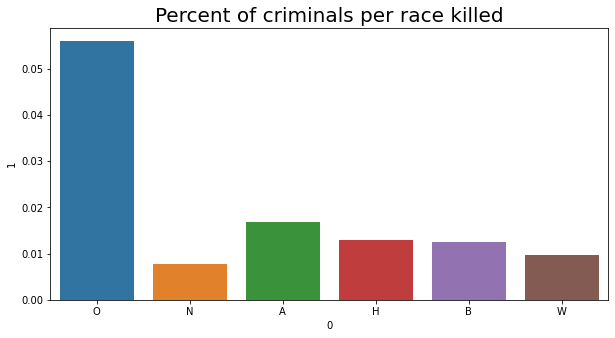

In [40]:
''' These data represent the total arrest in 2015, 2016, 2017: 
  https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-43
  https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/topic-pages/tables/table-21
  https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/tables/table-43
'''
a = fatal_police_shooting_us.groupby('race').size().sort_values()
percent_death_per_race_criminal = list()

total_criminal_cases={
    'White': 5753212*0.816 + 5858330*0.816 + 7/12*0.819*5626140,
    'Black': 2197140*0.816 + 2263112*0.816 + 7/12*0.819*2221697, 
    'Asian': 101064*0.816 + 103244*0.816 + 7/12*0.819*97049,
    'NativeAmerican': 174020*0.816 + 171185*0.816 + 7/12*0.819*196908,
    'Hispanic': 1204862 + 1221066 + 7/12*1190671,
    'Others': 23273*0.816 + 25610*0.816 + 7/12*0.819*21055
}

for race, total_death in a.iteritems():
  if race == 'W':
    death_per_race_criminal = total_death/total_criminal_cases['White']*100
  elif race == 'N':
    death_per_race_criminal = total_death/total_criminal_cases['NativeAmerican']*100
  elif race == 'A':
    death_per_race_criminal = total_death/total_criminal_cases['Asian']*100
  elif race == 'H':
    death_per_race_criminal = total_death/total_criminal_cases['Hispanic']*100
  elif race == 'B':
    death_per_race_criminal = total_death/total_criminal_cases['Black']*100
  else:
    death_per_race_criminal = total_death/total_criminal_cases['Others']*100
  percent_death_per_race_criminal.append((race, death_per_race_criminal))

percent_death_per_race_criminal = pd.DataFrame(percent_death_per_race_criminal)
plt.figure(figsize=(10,5))
sns.barplot(x=percent_death_per_race_criminal[0], y=percent_death_per_race_criminal[1])
plt.title('Percent of criminals per race killed',fontdict={'fontsize':20})


Calculating steps:
* Since the datasets provided from FBI:UCR don't have categories for non-Hispanic of each of the other races, I calculated that by multiplying total cases of each race by the percentage of non-Hispanic cases, assuming that each of the other races shares the same proportion of Hispanic/non-Hispanic.
* Note that the FatalPoliceShootingUS only have records from Jan 2015 to July 2017. However, the datasets from FBI:UCR have the total cases for each year 2015, 2016, and 2017. Therefore, we have to add the total of each of the year to find the total cases during the period. Besides, for 2017, assuming number of cases are not affected by the time of a year, I multiply the total cases in 2017 by 7/12 to get the estimate of total cases in the first 7 months of 2017.

Results:
* The percentage of criminals being shot for the Others race is disproportionally high.
* Among the other races, although there are differences between the proportion of each race being killed, the bias is not significant.

Text(0.5, 1.0, 'Total victims each month from January 2015 to July 2017')

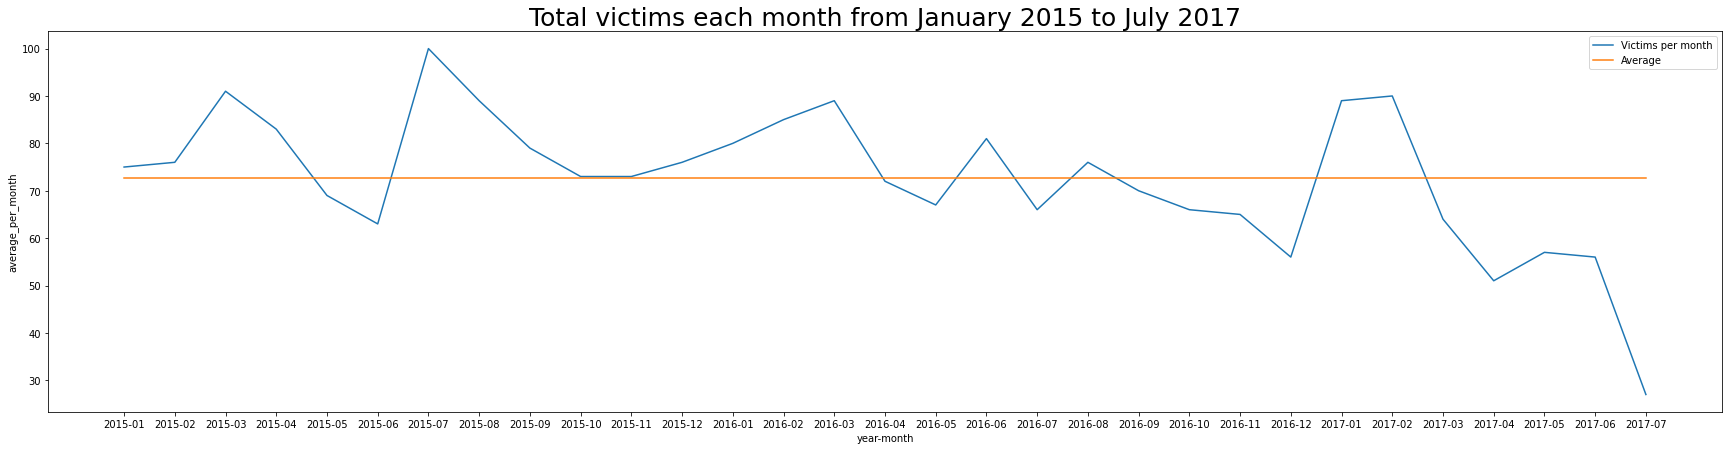

In [41]:
fatal_police_shooting_us['month'] = fatal_police_shooting_us['date'].dt.month#.value_counts()
fatal_police_shooting_us['month'] = fatal_police_shooting_us['month'].astype('str')
fatal_police_shooting_us['month'] = fatal_police_shooting_us['month'].map(lambda x: '0'+ x if len(x)==1 else x)

fatal_police_shooting_us['year'] = fatal_police_shooting_us['date'].dt.year

fatal_police_shooting_us['year-month'] = fatal_police_shooting_us['year'].astype('str') + '-' + fatal_police_shooting_us['month'].astype('str')
shooting_per_month = fatal_police_shooting_us.groupby('year-month').size()

fig, ax = plt.subplots(figsize=(30,7))
ax.set_title('Total victims each month from January 2015 to July 2017', fontdict={'fontsize':25})
sns.lineplot(ax=ax, x=shooting_per_month.index, y=shooting_per_month)

###########
shooting_per_month = pd.DataFrame(shooting_per_month)
shooting_per_month['average_per_month'] = shooting_per_month[0].mean()

sns.lineplot(ax=ax, x=shooting_per_month.index, y=shooting_per_month['average_per_month'])
ax.legend(labels=['Victims per month','Average'])

Time and total death are not correlated. This backs up the assumption made in the previous calculation.

<Figure size 1440x360 with 0 Axes>

Text(0.5, 1.0, 'Total fatal shots in each state')

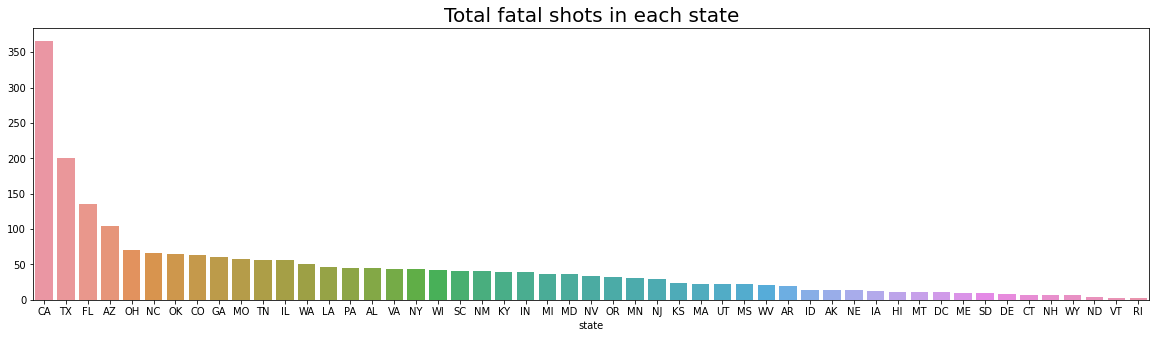

In [43]:
a = fatal_police_shooting_us.groupby('state').size().sort_values(ascending=False)
plt.figure(figsize=(20,5))
plt.title('Total fatal shots in each state', fontdict={'fontsize':20})
sns.barplot(x = a.index, y = a)

CA, TX, FL and have most police fatal shooting cases


Same as cases per race, for this cases per city, we also need to divide the number by total arrest cases per city.


https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-69

https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-22

https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/topic-pages/tables/table-69

<Figure size 1440x360 with 0 Axes>

Text(0.5, 1.0, 'Fatal shot per arrest in each state')

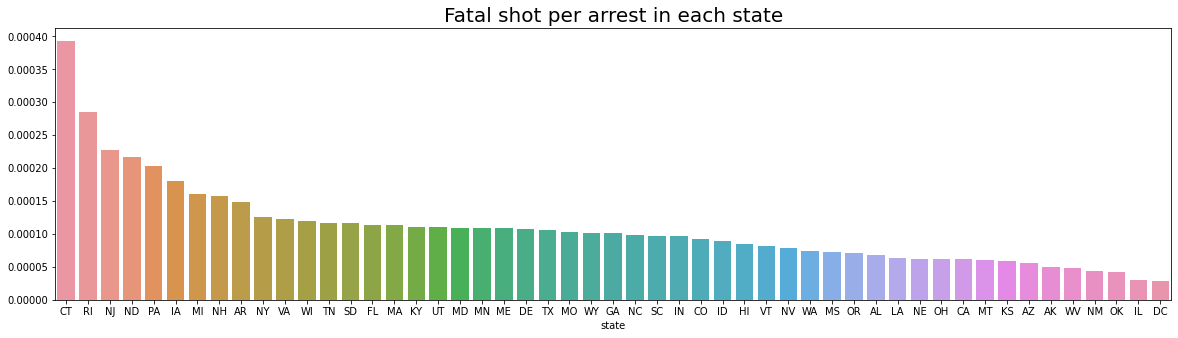

In [45]:
arrest_by_state = pd.read_csv('/content/drive/My Drive/data/arrest_by_state.csv')

arrest_by_state['2015'] = arrest_by_state['2015'].str.replace(',','')
arrest_by_state['2,016'] = arrest_by_state['2,016'].str.replace(',','')
arrest_by_state['2,017'] = arrest_by_state['2,017'].str.replace(',','')
arrest_by_state['2015'] = arrest_by_state['2015'].astype('int64')
arrest_by_state['2,016'] = arrest_by_state['2,016'].astype('int64')
arrest_by_state['2,017'] = arrest_by_state['2,017'].astype('int64')

arrestfrom2015to2017 = arrest_by_state['2015'] + arrest_by_state['2,016'] + arrest_by_state['2,017']*7/12
arrestfrom2015to2017.index = arrest_by_state['Unnamed: 0'].str.strip()

#https://gist.github.com/rogerallen/1583593

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York6': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_state_abbrev = { state.upper(): ab for state, ab in us_state_abbrev.items()}
arrestfrom2015to2017.index = arrestfrom2015to2017.index.map(us_state_abbrev)
death_per_arrest = fatal_police_shooting_us.groupby('state').size().sort_index() / arrestfrom2015to2017.sort_index()
plt.figure(figsize=(20,5))
plt.title('Fatal shot per arrest in each state', fontdict={'fontsize':20})
sns.barplot(x = death_per_arrest.sort_values().index, y = death_per_arrest.sort_values(ascending=False))

This chart illustrates better the aggressivity of the police officers. Officers in CT, RI, and NJ are most likely to cause fatal shots.

# **Modeling To Predict Race Of Victims**

In [67]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import inspection
from sklearn import metrics
from sklearn import ensemble

FEATURE_RACE = ['percent_completed_hs','poverty_rate','Median Income',
               'share_white','share_black','share_asian',
               'share_native_american','share_hispanic','manner_of_death', 
               'armed', 'gender', 'age', 'signs_of_mental_illness', 
               'threat_level']
TARGET_RACE = 'race'

X_race = data[FEATURE_RACE]
y_race = data[TARGET_RACE]

In [68]:
object_cols = (X_race.dtypes == 'object')[X_race.dtypes == 'object'].index
X_race[object_cols].describe()

RACE_OH_FEATURES = ['threat_level', 'armed']  # since these variables are nominal
RACE_LABEL_FEATURES = ['manner_of_death', 'gender', 'signs_of_mental_illness'] # since these are binary variables

,manner_of_death,armed,gender,signs_of_mental_illness,threat_level
count,1938,1938,1938,1938,1938
unique,2,58,2,2,3
top,shot,gun,M,False,attack
freq,1806,1074,1853,1457,1251


In [69]:
# reduce categories in 'armed' column by removing rarely appeared (<=7) values
s = X_race['armed'].value_counts() 
armed_others = list(s[s<=7].index) 
X_race['armed'] = X_race['armed'].apply(lambda x: 'others' if x in armed_others else x)
X_race['armed'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


gun               1074
knife              276
unarmed            148
vehicle            142
others             103
toy weapon          87
undetermined        84
machete             15
unknown weapon       9
Name: armed, dtype: int64

In [70]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# splitting train/test
X_race_train, X_race_test, y_race_train, y_race_test  = model_selection.train_test_split(X_race,y_race,train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=0)

# One Hot Encoding 
encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

X_race_OH_train_cols = pd.DataFrame(encoder.fit_transform(X_race_train[RACE_OH_FEATURES]))
X_race_OH_test_cols = pd.DataFrame(encoder.transform(X_race_test[RACE_OH_FEATURES]))

X_race_train = X_race_train.drop(RACE_OH_FEATURES, axis=1)
X_race_test = X_race_test.drop(RACE_OH_FEATURES, axis=1)

X_race_OH_train_cols.columns = encoder.get_feature_names()
X_race_OH_test_cols.columns = encoder.get_feature_names()

X_race_OH_train_cols.index = X_race_train.index
X_race_OH_test_cols.index = X_race_test.index

X_race_train = pd.concat([X_race_train, X_race_OH_train_cols], axis=1)
X_race_test = pd.concat([X_race_test, X_race_OH_test_cols], axis=1)

# Label Encoding
encoder = preprocessing.LabelEncoder()

for col in RACE_LABEL_FEATURES:
  X_race_train[col] = encoder.fit_transform(X_race_train[col])
  X_race_test[col] = encoder.transform(X_race_test[col])

**KNN Classifier**

---



In [71]:
from sklearn.neighbors import KNeighborsClassifier

race_knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10, 13]}

gridsearch_race_knn = model_selection.GridSearchCV(estimator=race_knn, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="accuracy")
gridsearch_race_knn.fit(X_race_train, y_race_train)

print('\n\nK Nearest Neighbors CV Accuracy Score: {}'.format(abs(gridsearch_race_knn.best_score_)))
print('Best parameters: {}'.format(gridsearch_race_knn.best_params_))

test_prediction = gridsearch_race_knn.predict(X_race_test)
print('K Nearest Neighbors Test Accuracy Score: {}'.format(metrics.accuracy_score(test_prediction, y_race_test)))
print(metrics.classification_report(y_race_test, test_prediction))

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 10, 13]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)



K Nearest Neighbors CV Accuracy Score: 0.49806451612903224
Best parameters: {'n_neighbors': 7}
K Nearest Neighbors Test Accuracy Score: 0.5
              precision    recall  f1-score   support

           A       0.33      0.10      0.15        10
           B       0.41      0.46      0.43       102
           H       0.37      0.34      0.35        65
           N       0.00      0.00      0.00         8
           O       0.00      0.00      0.00         6
           W       0.59      0.63      0.61       197

    accuracy                           0.50       388
   macro avg       0.28      0.25      0.26       388
weighted avg       0.48      0.50      0.49       388



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**ADA Boost Classifier**

---



In [72]:
race_abc = ensemble.AdaBoostClassifier()
param_grid = {'n_estimators': [40, 50, 60]}

gridsearch_race_abc = model_selection.GridSearchCV(estimator=race_abc, 
                                                  param_grid=param_grid,
                                                  cv=5,
                                                  scoring="accuracy")
gridsearch_race_abc.fit(X_race_train, y_race_train)

print('\n\nADA Boost CV Accuracy Score: {}'.format(abs(gridsearch_race_abc.best_score_)))
print('Best parameters: {}'.format(gridsearch_race_abc.best_params_))

test_prediction = gridsearch_race_abc.predict(X_race_test)
print('ADA Boost Test Accuracy Score: {}'.format(metrics.accuracy_score(y_race_test, test_prediction)))
print(metrics.classification_report(y_race_test, test_prediction))

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [40, 50, 60]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='accuracy',
             verbose=0)



ADA Boost CV Accuracy Score: 0.38258064516129037
Best parameters: {'n_estimators': 50}
ADA Boost Test Accuracy Score: 0.5798969072164949
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        10
           B       0.59      0.59      0.59       102
           H       0.45      0.45      0.45        65
           N       0.25      0.38      0.30         8
           O       0.08      0.17      0.11         6
           W       0.69      0.67      0.68       197

    accuracy                           0.58       388
   macro avg       0.35      0.37      0.36       388
weighted avg       0.59      0.58      0.58       388



**Results**

---



Text(0.5, 1.0, 'ADA Boost Classifier')

Text(0.5, 1.0, 'KNN Classifier')

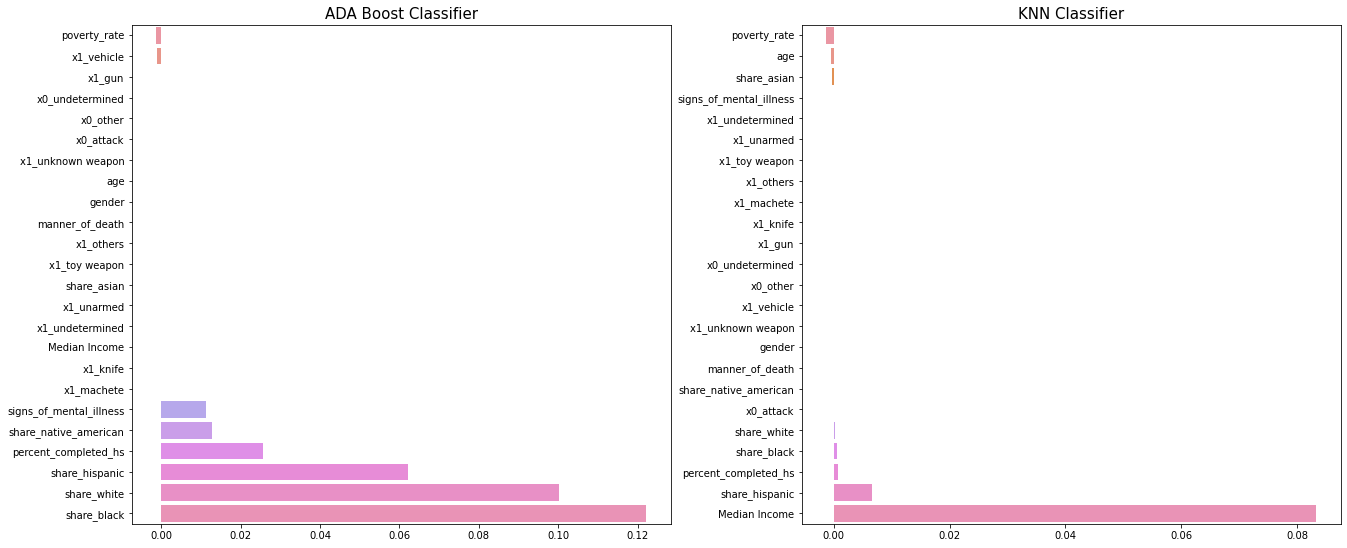

In [74]:
from sklearn.inspection import permutation_importance

# KNN Boosting
result = permutation_importance(gridsearch_race_knn.best_estimator_, X_race_test,
                                y_race_test, n_repeats=10, random_state=0)
race_knn_feature_importance = pd.Series(result.importances_mean)
race_knn_feature_importance.index = X_race_train.columns
race_knn_feature_importance = race_knn_feature_importance.sort_values()

# ADA Boost Classifier
result = permutation_importance(gridsearch_race_abc.best_estimator_, X_race_test,
                                y_race_test, n_repeats=10, random_state=0)
race_abc_feature_importance =  pd.Series(result.importances_mean)
race_abc_feature_importance.index = X_race_train.columns
race_abc_feature_importance = race_abc_feature_importance.sort_values()

fig, ax = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout(pad=10)
sns.barplot(ax=ax[0],y=race_abc_feature_importance.index, x=race_abc_feature_importance)
ax[0].set_title('ADA Boost Classifier', fontdict={'fontsize': 15})
sns.barplot(ax=ax[1],y=race_knn_feature_importance.index, x=race_knn_feature_importance)
ax[1].set_title('KNN Classifier', fontdict={'fontsize': 15})

For both models, the importance of most features too minor compared to the top ones. Moreover, these two models prioritize features differently predicting the output. For ADA Boost, share of each races are the most important and Median Income and age has almost no effect. In contrast, KNN Classifier put Median Income as the most important, and age is the second feature while predicting the output.
These two models seems unreliable to use.  

Text(0.5, 1.0, 'Accuracy between KNN and ADABoost')

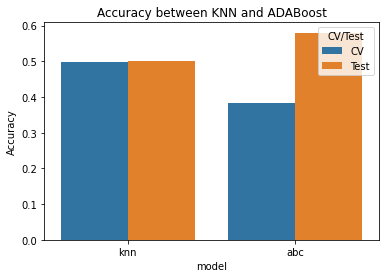

In [75]:
# accuracy
knn_CV = abs(gridsearch_race_knn.best_score_)
knn_test = abs(gridsearch_race_knn.score(X_race_test, y_race_test))
abc_CV = abs(gridsearch_race_abc.best_score_)
abc_test = abs(gridsearch_race_abc.score(X_race_test, y_race_test))
age_models = pd.DataFrame({'Accuracy': [knn_CV, knn_test, abc_CV, abc_test],
                           'CV/Test':['CV','Test','CV','Test'],
                           'model': ['knn','knn','abc','abc']})
plt.title('Accuracy between KNN and ADABoost')
sns.barplot(x=age_models['model'], y=age_models['Accuracy'], hue=age_models['CV/Test'])

The ADA Boost Classifier model does suprisingly better in the test set than in the training set. KNN and ADABoost are comparatively equal in making decisions about the victim's race. However, the accuracy for both models are too low, only 0.5. With these accuracy scores and the different behaviors of the two models discussed above, we can conclude that using these models' prediction are not better than blind guess. The data collected is not enough to predict the victim's race.